# Learning BN parameters using EM

In this excercise we will work with real data on Traffic Accidents in the UK during 2015. The idea is to assume a BN structure and learn the parameters using EM. 

We first load the data

In [1]:
import numpy as np
from lib import Message_passing_BN as mp
import warnings
import pickle
warnings.filterwarnings('ignore')
from IPython.display import Image

In [2]:
pickle_file='accident_data.pickle'

with open(pickle_file, 'rb') as f:
    data= pickle.load(f)

#Labels contain the name of each variable
#Samples contain the variable values per accedient
Samples=data[0]
labels=data[1]

print("%d accidents in the data base, each characterized by %d variables\n" %(Samples.shape[0],Samples.shape[1]))

print("The variables are")
print(labels)

140056 accidents in the data base, each characterized by 8 variables

The variables are
['Day_of_Week', 'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Accident_Severity', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Pedestrian_Crossing-Physical_Facilities']


The encoding for all variables in the data can be accessed at this [Brief guide to road accidents and safety data](https://data.gov.uk/dataset/road-accidents-safety-data/resource/394c8dac-1a7d-49b0-97ff-62df43b00f42)

For simplicity, we will work with the following set of four variables:

* Day_of_Week (1-Sunday, 2-Monday, ...)

* Weather_Conditions 
        1	Fine no high winds
        2	Raining no high winds
        3	Snowing no high winds
        4	Fine + high winds
        5	Raining + high winds
        6	Snowing + high winds
        7	Fog or mist
        8	Other
        9	Unknown (this will be labelled as -1)
        -1	Data missing or out of range
        
* Accident Severity
        1   Fatal
        2   Serious
        3   Slight
* Did_Police_Officer_Attend_Scene_of_Accident
        1   Yes
        2   No
        3   No - accident was reported using a self completion  form (self rep only)
        

For each accident, we assume we do not observe all the variables (otherwise it does not make sense tu run the EM algorithm). We know simply declare unknown certain variables chosen at random. Also, we transform the data to represent indexes in the corresponding alphabet (from 0 to max-1)

In [3]:
Samples_matrix=Samples[:,[0,4,5,6]]

#We label unknown weather as -1 

Samples_matrix[Samples_matrix[:,1]==9,1]=-1

#We index from 0

Samples_matrix=Samples_matrix-1

for i in range(Samples.shape[0]):
    num_hidden=np.random.randint(1,5,1)-1
    index_hidden=np.random.randint(0,3,num_hidden)
    Samples_matrix[i,index_hidden]=-1
    

# Excercise 1

Use EM to train the following network

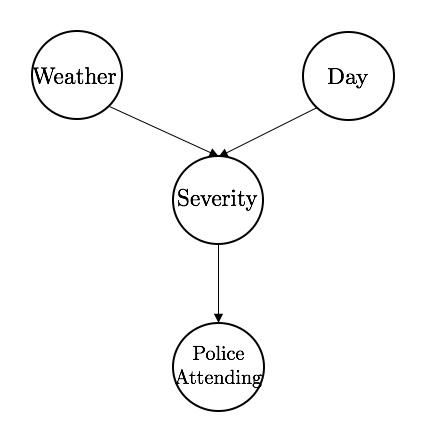

In [4]:
Image(filename='files/Mod_1.png')

First step is to generate random initial CPDs 

In [5]:
v_card=[7,8,3,3] #Vector of cardinalities 

CPD_d=np.random.rand(v_card[0],1)
CPD_d/=CPD_d.sum()

CPD_w=np.random.rand(v_card[1],1)
CPD_w/=CPD_w.sum()

#p(severity|day,weather)
length_table=v_card[0]*v_card[1]*v_card[2]
CPD_severity=np.zeros([length_table,1])
for i in range(v_card[0]*v_card[1]):
    aux=np.random.rand(v_card[2],1)
    aux/=aux.sum()
    CPD_severity[i*v_card[2]:(i+1)*v_card[2]]=aux

#p(Police Attendng|Severity)
length_table=v_card[2]*v_card[3]
CPD_attending=np.zeros([length_table,1])
for i in range(v_card[2]):
    aux=np.random.rand(v_card[3],1)
    aux/=aux.sum()
    CPD_attending[i*v_card[3]:(i+1)*v_card[3]]=aux


Now, we create the factor graph using the provided library

In [6]:
#Variable nodes

node_day=mp.create_var_node(ID=0,cardinality=v_card[0],neighbor_order=[0,2],observed_value_index=-1)
node_weather=mp.create_var_node(ID=1,cardinality=v_card[1],neighbor_order=[1,2],observed_value_index=-1)
node_severity=mp.create_var_node(ID=2,cardinality=v_card[2],neighbor_order=[2,3],observed_value_index=-1)
node_attending=mp.create_var_node(ID=3,cardinality=v_card[3],neighbor_order=[3],observed_value_index=-1)

list_var_nodes=[node_day,node_weather,node_severity,node_attending]

#Factor nodes
list_neigh_factor=[[node_day],[node_weather],[node_day,node_weather,node_severity],[node_severity,node_attending]]

factor_0=mp.create_factor_node(ID=0,neighbors=list_neigh_factor[0],CPD=CPD_d)
factor_1=mp.create_factor_node(ID=1,neighbors=list_neigh_factor[1],CPD=CPD_w)
factor_2=mp.create_factor_node(ID=2,neighbors=list_neigh_factor[2],CPD=CPD_severity)
factor_3=mp.create_factor_node(ID=3,neighbors=list_neigh_factor[3],CPD=CPD_attending)

list_factor_nodes=[factor_0,factor_1,factor_2,factor_3]

In [7]:
# The following function simply runs BP for a given observation 

def run_BP(data_index,Samples_matrix,list_var_nodes,list_factor_nodes,BP_iterations):
    
    #We update those variables that have been observed in the data_index-th Sample
    for index,node in enumerate(list_var_nodes):
        mp.initialize_variable(node,Samples_matrix[data_index,index])
    
    for index,factor_node in enumerate(list_factor_nodes):    
        mp.initialize_factor_msgs(factor_node,neighbors=list_neigh_factor[index])
    
    #We run message passing
    for l in range(BP_iterations):

        #Factor update
        for factor_node in list_factor_nodes:      
            mp.update_factor_to_var(factor_node)
    
        #Variable update
        for var_node in list_var_nodes:
            mp.update_var_to_factor(var_node)

Before defining the main EM Loop, we define first two intermediate functions to process the $i$-th data given the current estimate to the CPD tables. Given the observation, the goal is to compute the joint marginals 

p(day), p(weather), p(severity,day,weather), p(police_attending, severity)


In [8]:
# The following function is used to compute joint marginals p(x_i,x_pa_i)

def compute_joint_probabilities(list_var_nodes,list_factor_nodes,v_card):

    list_joints=[]
    
    #YOUR CODE HERE!!
    
    #p(day)
    list_joints.append(mp.compute_var_marginal(list_var_nodes[0])) 
    
    #p(weather)
    list_joints.append(mp.compute_var_marginal(list_var_nodes[1]))
    
    #p(day,weather,severity)
    
    factor=list_factor_nodes[2]
    
    msg_1=factor['input_msgs'][0]['table'].reshape(-1,)
    msg_2=factor['input_msgs'][1]['table'].reshape(-1,)
    msg_3=factor['input_msgs'][2]['table'].reshape(-1,)
    
    aux=np.zeros([factor['CPD'].shape[0],1])
    
    for position,cpd_value in enumerate(factor['CPD']):        
        
        indexes=mp.CPD_position_to_variable_index(position,[v_card[0],v_card[1],v_card[2]],v_card[0]*v_card[1]*v_card[2])
        
        aux[position]+=cpd_value*np.exp(msg_1[indexes[0]]+msg_2[indexes[1]]+msg_3[indexes[2]])
    
    list_joints.append(aux/np.sum(aux))
    
    #p(severity,attending)    
    
    factor=list_factor_nodes[3]
    msg_1=factor['input_msgs'][0]['table'].reshape(-1,)
    
    aux=np.zeros([factor['CPD'].shape[0],1])
    
    for position,cpd_value in enumerate(factor['CPD']):
        
        indexes=mp.CPD_position_to_variable_index(position,[v_card[2],v_card[3]],v_card[2]*v_card[3])
        
        aux[position]+=cpd_value*np.exp(msg_1[indexes[0]])
        
    list_joints.append(aux/np.sum(aux))    
      
        
    return list_joints    

## EM main Loop

In [9]:
EM_iterations=5
BP_iterations=7     #num_variables+1
N_samples=300       #up to Samples_matrix.shape[0]

for iteration in range(EM_iterations): 
    
    print("EM iteration=%d" %(iteration))
    #E-Step --> Compute the Expected Number of Configurations. This is a loop over the data that could 
    #be done in parallalel (or even in a noisy way)
    
    Nd=np.zeros(CPD_d.shape)   
    Nw=np.zeros(CPD_w.shape)    
    Ns=np.zeros(CPD_severity.shape)    
    Na=np.zeros(CPD_attending.shape)    

    
    for i in range(N_samples): 
    
        #We run BP with the observations for the i-th data
        run_BP(i,Samples_matrix,list_var_nodes,list_factor_nodes,BP_iterations)
        
        #Given MP messages, we update the counting matrices Nx (E-STEP)        
        
        joint_probs=compute_joint_probabilities(list_var_nodes,list_factor_nodes,v_card)

        Nd+=joint_probs[0] 
        Nw+=joint_probs[1]
        Ns+=joint_probs[2]
        Na+=joint_probs[3]
  
            
    #Normalization  (M-STEP)
    
    CPD_d=Nd/np.sum(Nd)
    CPD_w=Nw/np.sum(Nw)
    
    for j in range(v_card[0]*v_card[1]):
        aux=Ns[j*v_card[2]:(j+1)*v_card[2]]
        CPD_severity[j*v_card[2]:(j+1)*v_card[2]]=aux/np.sum(aux)
        
    for j in range(v_card[2]):
        aux=Na[j*v_card[3]:(j+1)*v_card[3]]
        CPD_attending[j*v_card[3]:(j+1)*v_card[3]]=aux/np.sum(aux)        
     
    
    #Finally, update the factors
    factor_0['CPD']=CPD_d.reshape(CPD_d.shape[0],)
    factor_1['CPD']=CPD_w.reshape(CPD_w.shape[0],)
    factor_2['CPD']=CPD_severity.reshape(CPD_severity.shape[0],)
    factor_3['CPD']=CPD_attending.reshape(CPD_attending.shape[0],)

EM iteration=0
EM iteration=1
EM iteration=2
EM iteration=3
EM iteration=4


In [10]:
CPD_attending

array([[ 0.51051932],
       [ 0.29439561],
       [ 0.19508507],
       [ 0.38162543],
       [ 0.51610457],
       [ 0.10227   ],
       [ 0.00562594],
       [ 0.44081651],
       [ 0.55355756]])

## Excercise 2

Use EM to train the following mode, which now includes a binary latent variable $Z$  that **we never observe**. The use of latent variable model is very frequent in Bayesian Reasoning and can help to reduce the number of parameters to learn, as we assume there exists an underlying latent variable that explains different variables.

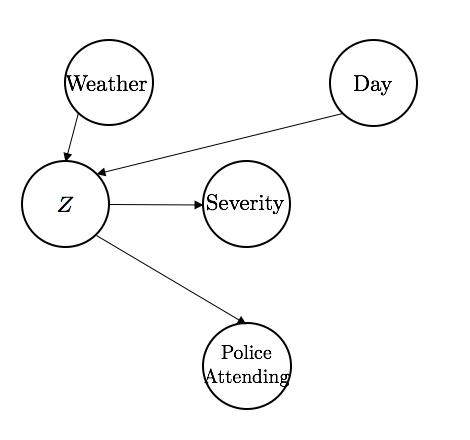

In [11]:
Image(filename='files/Mod_2.png')

In [12]:
## YOUR CODE HERE

In [15]:
factor=list_factor_nodes[3]

In [17]:
msg=factor['input_msgs'][0]['table']

In [18]:
msg

array([[-100.],
       [-100.],
       [ 100.]])